In [1]:
%matplotlib inline
import yt
import numpy as np
from galaxy_analysis.plot.plot_styles import *
from galaxy_analysis.analysis import Galaxy
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [3]:
wdir = "/home/aemerick/work/enzo_runs/mixing_experiment/AGB1/"
wdir = "/home/aemerick/work/enzo_runs/sn_H2atten_H2sh/"
wdir = './test/'

gal = Galaxy('DD0419',wdir=wdir)

Parsing Hierarchy : 100%|██████████| 2002/2002 [00:00<00:00, 7918.98it/s]


In [6]:
#
# Try the correlation coefficient
#

metal_field = 'Na_Fraction'

width = 5.0*yt.units.pc
rvals = np.arange(0.0, 600.0, 10.) * yt.units.pc + 0.5*width

rand_x = 0.0
rand_y = 0.0

center = gal.ds.domain_center.to('pc') + np.array([rand_x, rand_y, 0.0])*yt.units.pc

sp     = gal.ds.sphere( center, np.max(rvals) + 2.0*width)

coeff = np.zeros(np.size(rvals))

for i in np.arange(np.size(rvals)-1):
    
    
    s_x      = sp[metal_field].value
    r_x      = sp['spherical_radius'].to('pc').value
    
    select   = (r_x >= (rvals[i] - 0.5*width)) * (r_x < (rvals[i] + 0.5*width))
    
    coeff[i] = np.corrcoef(s_x[select])


In [38]:
#fig,ax = plt.subplots()
#fig.set_size_inches(6,6)
#
#ax.plot(rvals, coeff, lw = 3, color = 'black')

In [10]:
#
#
# 1) Pick N random points in the galaxy (Rvec)
# 2) compute S_x at each point
# 3) For each point in Rvec, pick N random points that are a distance r from that point (S_x')
# 4) Compute correlation between S_x and S_x'
# 5) Repeat for increasing r
#

In [4]:
#
#
#

metal_field = "Ba_Fraction"

N      = 1000
rmax   = 600.0
domain_width = gal.ds.domain_width
center = gal.ds.domain_center.to('pc') / domain_width



theta = np.random.rand(N) * np.pi * 2.0
r_cyl = np.random.rand(N) * 600.0**2

xvec  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[0] + center[0]
yvec  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[1] + center[1]
zvec  = (np.zeros(N))                    * yt.units.pc / domain_width[2] + center[2]

pt_x  = [ gal.ds.r[ [xvec[i].value, yvec[i].value, zvec[i].value] ] for i in np.arange(N)]
S_x   = np.array([p[metal_field][0] for p in pt_x])

rsample   = np.arange(0,600.0,10.0)
corrcoeff = np.zeros(np.size(rsample))

for i in np.arange(np.size(rsample)):
    
    theta = np.random.rand(N) * np.pi * 2.0
    r_cyl = np.random.rand(N) * (rsample[i])**2.0

    xprime  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[0] + xvec
    yprime  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[1] + yvec
    zprime  = (np.zeros(N))                    * yt.units.pc / domain_width[2] + zvec
    
    pt_x_prime = [ gal.ds.r[ [xprime[j].value,yprime[j].value,zprime[j].value]] for j in np.arange(N)]
    S_x_prime  = np.array([p[metal_field][0] for p in pt_x_prime])
    
    corrcoeff[i] = pearsonr(S_x, S_x_prime)[0]
    
ba_coeff = 1.0 * corrcoeff

In [ ]:
#
#
#

metal_field = "O_Fraction"

N      = 1000
rmax   = 600.0
domain_width = gal.ds.domain_width
center = gal.ds.domain_center.to('pc') / domain_width



theta = np.random.rand(N) * np.pi * 2.0
r_cyl = np.random.rand(N) * 600.0**2

xvec  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[0] + center[0]
yvec  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[1] + center[1]
zvec  = (np.zeros(N))                    * yt.units.pc / domain_width[2] + center[2]

pt_x  = [ gal.ds.r[ [xvec[i].value, yvec[i].value, zvec[i].value] ] for i in np.arange(N)]
S_x   = np.array([p[metal_field][0] for p in pt_x])

rsample   = np.arange(0,600.0,10.0)
corrcoeff = np.zeros(np.size(rsample))

for i in np.arange(np.size(rsample)):
    
    theta = np.random.rand(N) * np.pi * 2.0
    r_cyl = np.random.rand(N) * (rsample[i])**2.0

    xprime  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[0] + xvec
    yprime  = (np.sqrt(r_cyl) * np.cos(theta)) * yt.units.pc / domain_width[1] + yvec
    zprime  = (np.zeros(N))                    * yt.units.pc / domain_width[2] + zvec
    
    pt_x_prime = [ gal.ds.r[ [xprime[j].value,yprime[j].value,zprime[j].value]] for j in np.arange(N)]
    S_x_prime  = np.array([p[metal_field][0] for p in pt_x_prime])
    
    corrcoeff[i] = pearsonr(S_x, S_x_prime)[0]
    
O_coeff = 1.0 * corrcoeff

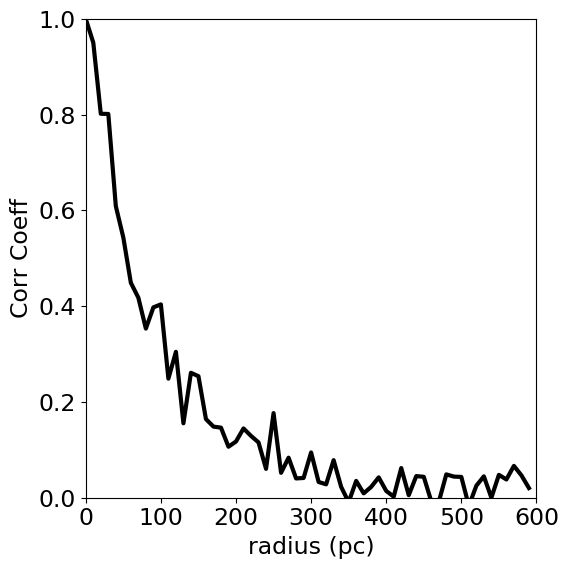

In [46]:
fig,ax = plt.subplots()
fig.set_size_inches(6,6)

ax.plot(rsample, corrcoeff, lw = 3, color = 'black')
ax.set_xlim(0,600)
ax.set_ylim(0.0,1.0)

ax.set_xlabel(r'radius (pc)')
ax.set_ylabel(r'Corr Coeff')

plt.tight_layout()

fig.savefig('AGB_corr_DD0500.png')



In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(6,6)

ax.plot(rsample, O_coeff,  lw = 3, color = 'black', label = 'O')
ax.plot(rsample, Ba_coeff, lw = 3, color = 'black', ls = '--', label = 'Ba')

ax.set_xlim(0,600)
ax.set_ylim(0.0,1.0)

ax.set_xlabel(r'radius (pc)')
ax.set_ylabel(r'Corr Coeff')
ax.legend(loc='best')

plt.tight_layout()

fig.savefig('AGB_SNe_DD0419.png')

